# Profit Prediction
### DALI 2024 Spring Application - Machine Learning Track

We now develop models to predict if the profit of a purchase is above or below the median purchase profit (as determined by our exploratory analysis).  A superstore would likely have access to all features in the Superstore.csv dataset at order time except profit; that would likely have to be calculated later.  Therefore, it would be helpful to the superstore to have a lightweight model than can predict weather a purchase will be above or below the median profit at order time.  We use Shapley values a means to improve the interpretability of the models we choose (see the predictCategory notebook for an explination of Shapley values), and we deploy them to a Huggingface space.

In [ ]:
!pip install shap

In [ ]:
!pip install gradio

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, f1_score
import shap
import xgboost as xgb
import gradio as gr
import matplotlib.pyplot as plt
import joblib

## Preapre the Dataset

We first need to prepare the dataset for machine learning.  This involves loading it, generating correct class labels (above or below the median), generating feature vectors for each entry, and splitting it into train, validation and test sets.

Splitting the dataset into train, validation and test sets is important to prevent data leakage.  The purpose of each set is as follows:

- Train: The data to train the model on, refining it over time.
- Validation: The dataset on which to optimize performance when tuning hyperparameters.
- Test: The dataset to evaluate the model on after training and hyperparameter tuning.  This gives an indication of the model's real-world performace.

If we train on data outside the train dataset, we will artificially inflate our model's performance because the model will have seen the data in that set before.  Similarly, if we optimize our test set performance when tuning hyperparameters, the test set performance will be artifially inflated and we won't have good means of measuring the model's real world performance.  For this project, we use a 70-15-15 train test validation split.

In [ ]:
df = pd.read_csv('Superstore.csv')

Based on the results of our exploratory analysis, we choose 5 features that appear to be correlated most strongly with profit: region, product category, product sub-category, quantity, and discount.  We drop rows that contain null values for any of these columns.  We are assuming data entries are missing completely at random, so this should not introduce bias into the dataset.  

In [ ]:
df.dropna(subset=["Region", "Category", "Sub-Category", "Quantity", "Discount"], inplace=True)
print("Number of rows: " + str(len(df.index))) # make sure we still have enough data

Number of rows: 5923


In [ ]:
MEDIAN = 8.662 # from the exploratory analysis file
RANDOM_STATE = 42 # random seed to ensure results are reproducible

The below cell generates a feature vector for each row and generates the label for that row (1 for above median profit, 0 for less than or equal to the median profit)

In [ ]:
# turn region, category, and sub-category columns into vectors of numbers
region=np.unique(df['Region'], return_inverse=True)[1]
category=np.unique(df['Category'], return_inverse=True)[1]
subCategory=np.unique(df['Sub-Category'], return_inverse=True)[1]

# turn quantity, discount, and profit columns into vectors of numbers
quantity = df["Quantity"].to_numpy()
discount = df["Discount"].to_numpy()
profit = df["Profit"].to_numpy()

vectorizedDataset = np.empty((len(region), 5))
labels = np.empty(len(region))

# generate feature vectors
for i in range(0, len(region)):
  data = np.zeros((1, 5))
  data[0][0] = region[i]
  data[0][1] = category[i]
  data[0][2] = subCategory[i]
  data[0][3] = quantity[i]
  data[0][4] = discount[i]

  vectorizedDataset[i] = data

  if (profit[i] > MEDIAN):
    labels[i] = 1
  else:
    labels[i] = 0

In [ ]:
# shuffles the data and splits it into the train, test, and validation sets
train, test, trainLabels, testLabels = train_test_split(vectorizedDataset, labels, test_size=0.3, random_state=RANDOM_STATE)

In [ ]:
print(len(train))
print(len(trainLabels))
print()

print(len(test))
print(len(testLabels))

4146
4146

1777
1777


## Logistic Regression

The first model we try is Logistic Regression, which is essentially a single layer of a neural network.  It works well for binary classification tasks (which our classification task is), and serves as a solid and lightweight performance baseline for other ML approaches on this task.  It is also a nonlinear model, which seems especially useful given the results of our exploratory analysis.

One advantage of logistic regression is that it is highly interpretable.  The weights of logistic regression each correspond to an input feature, so we can use them to see which features are weighted most heavily when predicting profit.  This could also provide useful information to the superstore on which features most heavily influence weather a purchase will make above the median profit or not.  Comparing these weights to the shapley values of predictions will be an interesting exercise (see the predictCategory notebook for an explination of Shapley values).

### Cross-Validation

We perform a grid search for the logistic regression hyperparameters (see the predictCategory notebook for an explination of a grid search). This grid search takes advantage of three-fold cross validation.  In three-fold cross validation, our training dataset is randmly divided into three equal size subsets (folds).  The model is then evaluated three times, with each fold being used as the validation set across the three folds.  The f1 of the model is then averaged together from across the three folds.  

The primary disadvantage of cross validation is computational complexity and time retraining the model.  However, for the lightweight models we use in this notebook, the disadvantage is negligible.  This advantages of cross validation are as follows:
- We take advantage of the entire dataset for training and evaluation (as opposed to partitioning a seperate validation set)
- We generate a more robust estimate of the model's performance compared to a single train-test split

In [ ]:
param_grid = {"alpha": [0.01, 0.001, 0.0002, 0.0001, 0.0005, 0.00001], "max_iter": [500, 750, 1000, 1250, 1500]}

# sklearn paritions its own validation set from the train data we pass in an and stops training once performance on
# its validation set no longer improves after 5 epochs
# this early stopping is important to prevent overfitting
EARLY_STOPPING = True
VALIDATION_FRACTION = 0.2 # fraction of training data to use for validation

In [ ]:
f1_scorer = make_scorer(f1_score, average='weighted') # we want to optimize macro f1

# sklearn partitions part of our training set as a validation set and we stop early if validation set performance plateaus
LogReg = SGDClassifier(loss = 'log_loss', penalty="elasticnet", early_stopping=EARLY_STOPPING, validation_fraction=VALIDATION_FRACTION, random_state=RANDOM_STATE)

grid_search = GridSearchCV(estimator=LogReg, param_grid=param_grid, scoring=f1_scorer, cv=3)

grid_search.fit(train, trainLabels)

best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'alpha': 0.01, 'max_iter': 500}


In [ ]:
Log_Reg = SGDClassifier(loss = 'log_loss', penalty="elasticnet", alpha=best_params["alpha"], max_iter=best_params["max_iter"], early_stopping=EARLY_STOPPING, validation_fraction=VALIDATION_FRACTION, random_state=RANDOM_STATE)

Log_Reg.fit(train, trainLabels)

# save the best-performing model for deployment
joblib.dump(Log_Reg, 'Log_Reg.pkl')
predictions = Log_Reg.predict(test)

Logistic regression performs substantially better than a random guess, and would likely be usable for our classification task.  It is lightweight and would almost assuredly perform inference quicker than a neural network.  However, a neural network would likely make predictions more accurately.

In [ ]:
# evaluation of best-performing hyperparameters
print(classification_report(testLabels, predictions))

              precision    recall  f1-score   support

         0.0       0.72      0.72      0.72       997
         1.0       0.64      0.63      0.64       780

    accuracy                           0.68      1777
   macro avg       0.68      0.68      0.68      1777
weighted avg       0.68      0.68      0.68      1777



The below cell shows the weights of our logistic regression model.  We see that discount has a strong negative relationship with profit, which makes sense (the higher the discount, the less the superstore makes).  Quantity has a positive relationshup with profit which agin makes sense; the more a customer buys, the greater the superstore's overall profit.  Region and product category have positive relationships with profit (as we have defined the numerical labels for regions and product categories).  This is very useful information for the superstore; they might want to analyse their best performing product categories and regions they sell to, and reduce their operations to only those categories/regions.  Surprisingly, product sub-category has no relationship with profit.  I assume this is because the other features are far better predictiors of profit than product sub-category is; however, given the statistical test showing profit was correlated with product sub-category, I am surprised by this result.

In [ ]:
print(Log_Reg.coef_) # logistic regression weights

[[ 0.06920253  0.39894525  0.          0.27451635 -2.17535154]]


### Logistic Regression Shapley Values

We can use Shapley values as an additional means of interpetability.  See the predictCategory notebook for an explination of Shapley values.

### Citations
I learned about shapley values and how to use the library from:
- A Unified Approach to Interpreting Model Predictions by Lundberg et al.
- https://github.com/shap/shap    \
- https://shap.readthedocs.io/en/latest/

In [ ]:
explainer = shap.Explainer(Log_Reg, test)
shap_values = explainer(test)
shap_values.feature_names = ["Region", "Category", "Sub-Category", "Quantity", "Discount"]

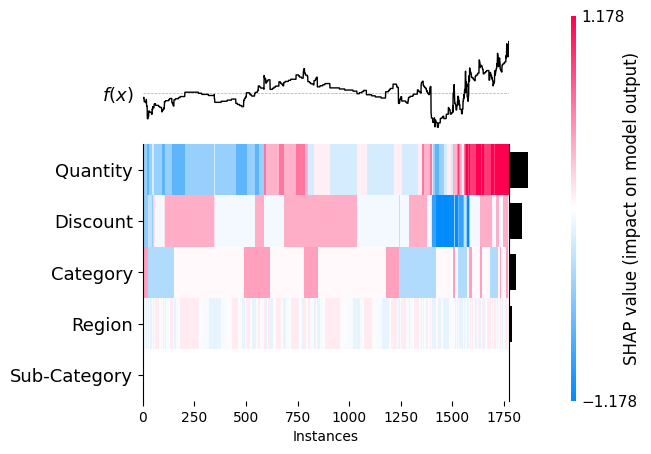

In [ ]:
shap.plots.heatmap(shap_values)

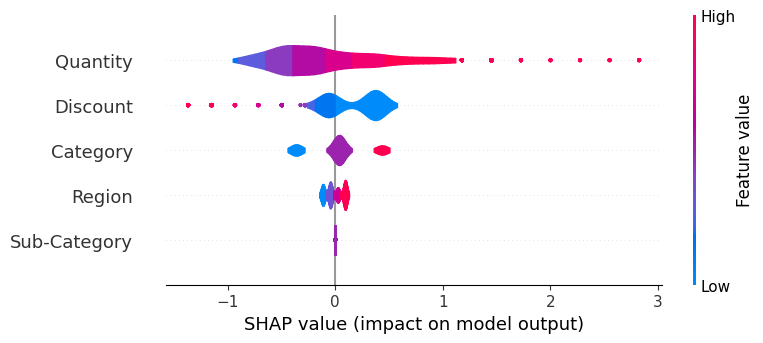

In [ ]:
# plot shapley value distributions
shap.plots.violin(shap_values, feature_names=["Region", "Category", "Sub-Category", "Quantity", "Discount"])

The results of the shapley values are largely consistent with the weights for the logistic regression.  Interestingly, shapley assigns far greater imporatance to quanity than discount, while discount has the greatest magnitude of weights in the Logistic Regression.  It seems that both of these features are extremely informative when predicting profit.

## Support Vector Machine

The next model we generate is a Support Vector Machine (SVM).  SVM finds the optimal hyperplane to seperate the purchases above the median profit and those below the median profit in the feature space.  It works well when there is a linear boundary between classes (in the absence of kernel transformations to transform our feature space to a higher dimensional space where they may be seprable by a new, higher-dimensional hyperplane).  Given the results of our exploratory analysis, I am interested to see how this model performs.  If it performs well, perhaps there is a linear relationship in our higher dimensional feature space despite the abscence of a linear relationship between any two individual features.

In [ ]:
# same grid search as logistic regression

f1_scorer = make_scorer(f1_score, average='weighted')

# the default loss function for SGDClassifier generates an SVM
SVM = SGDClassifier(penalty="elasticnet", early_stopping=EARLY_STOPPING, validation_fraction=VALIDATION_FRACTION, random_state=RANDOM_STATE)

grid_search = GridSearchCV(estimator=SVM, param_grid=param_grid, scoring=f1_scorer, cv=3)

grid_search.fit(train, trainLabels)

best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'alpha': 0.01, 'max_iter': 500}


In [ ]:
SVM = SGDClassifier(penalty="elasticnet", alpha=best_params["alpha"], max_iter=best_params["max_iter"], early_stopping=EARLY_STOPPING, validation_fraction=VALIDATION_FRACTION, random_state=RANDOM_STATE) # this is a linear SVM

SVM.fit(train, trainLabels)

joblib.dump(SVM, 'SVM.pkl')
predictions = SVM.predict(test)

Surprisingly, this model performs practically as well as logistic regression.  Perhaps by combining the 5 features of interest into a higher dimensional feature space, a distinct relationship emerged.  The shapley values might give insight into the primary features shaping this relationship.

In [ ]:
# evaluation of best-performing hyperparameters
print(classification_report(testLabels, predictions))

              precision    recall  f1-score   support

         0.0       0.73      0.66      0.70       997
         1.0       0.62      0.69      0.65       780

    accuracy                           0.68      1777
   macro avg       0.68      0.68      0.68      1777
weighted avg       0.68      0.68      0.68      1777



### SVM Shapley Values

In [ ]:
explainer = shap.Explainer(SVM, test)
shap_values = explainer(test)
shap_values.feature_names = ["Region", "Category", "Sub-Category", "Quantity", "Discount"]

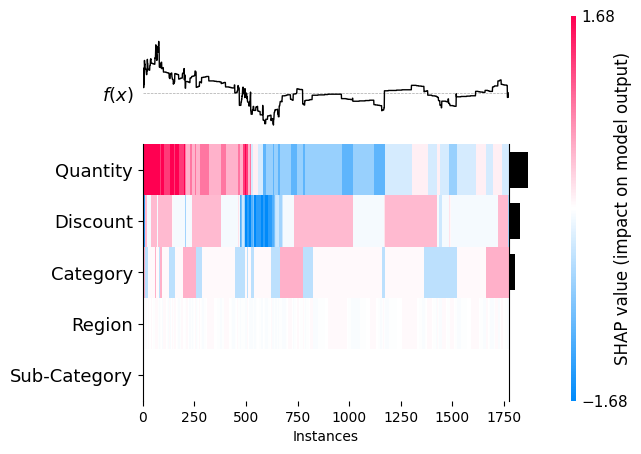

In [ ]:
shap.plots.heatmap(shap_values)

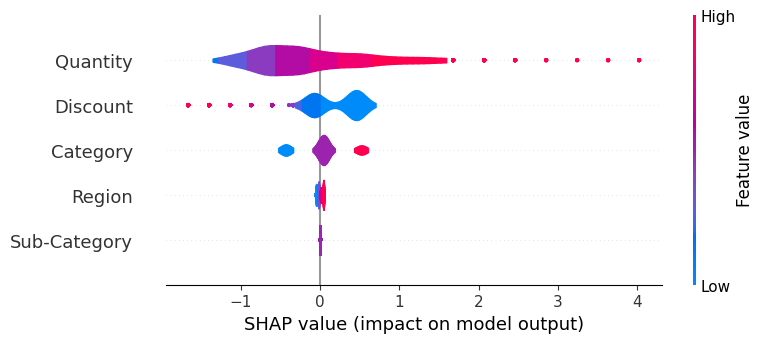

In [ ]:
shap.plots.violin(shap_values, feature_names=["Region", "Category", "Sub-Category", "Quantity", "Discount"])

As we can see, Quanity, Discount, and Category are the most influential features.  Region plays a minor role, and sub-cateogry has negligible influence.  This is roughly consistent with what we see in linear regression, supporting the relationships these models find in the data.  The de-emphasis on sub-category conti nues to surpise me; perhaps it is too noisy a feature to be useful to a model like SVM that is trying to find a fixed boundary.

## XGBoost

XGBoost, or Extreme Gradient Boosting, is a type of ensemble learning method.  It uses decision trees as its base learners, which partition the feature space into smaller regions and assign predictions to each region.  During each iteration, XGBoost fits a new decision tree to the residuals of the previous predictions.  The new tree is then added to the ensemble, and its predictions are combined with those of the existing trees to update the overall prediction.

XGBoost is a performant technique that is ideal for our classification task requiring a lightweight model.  Importantly, XGBoost can handle missing data well.  Its decision trees learn automatically how to best split the data based on the available information.  If we expect more missing data values in the future, XGBoost would be a good technqiue to mitigate their influence without needing imputation.

In [ ]:
param_grid = {
    'learning_rate': [0.1, 0.05, 0.01, 0.001],
    'max_depth': [3, 4, 5, 6, 7],
    'n_estimators': [100, 150, 200, 250, 300],
    'min_child_weight': [1, 2, 3, 4, 5, 6],
}

In [ ]:
f1_scorer = make_scorer(f1_score, average='weighted')

XGB = xgb.XGBClassifier()

grid_search = GridSearchCV(estimator=XGB, param_grid=param_grid, scoring=f1_scorer, cv=3)

grid_search.fit(train, trainLabels)

best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200}


In [ ]:
XGB = xgb.XGBClassifier(learning_rate=best_params["learning_rate"],
                        max_depth=best_params['max_depth'],
                        min_child_weight=best_params['min_child_weight'],
                        n_estimators=best_params['n_estimators'])

XGB.fit(train, trainLabels)

XGB.save_model('XGB.model')
predictions = XGB.predict(test)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [02:11:03] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


In [ ]:
print(classification_report(testLabels, predictions))

              precision    recall  f1-score   support

         0.0       0.79      0.76      0.77       997
         1.0       0.71      0.75      0.73       780

    accuracy                           0.75      1777
   macro avg       0.75      0.75      0.75      1777
weighted avg       0.75      0.75      0.75      1777



### XGBoost Shapley Values

In [ ]:
explainer = shap.Explainer(XGB, test)
shap_values = explainer(test)
shap_values.feature_names = ["Region", "Category", "Sub-Category", "Quantity", "Discount"]

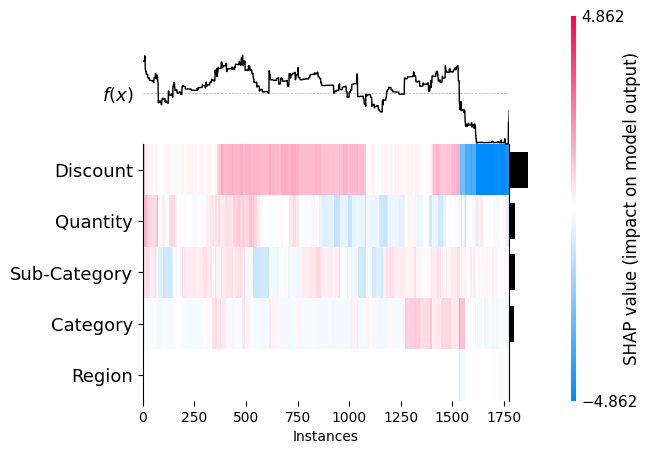

In [ ]:
shap.plots.heatmap(shap_values)

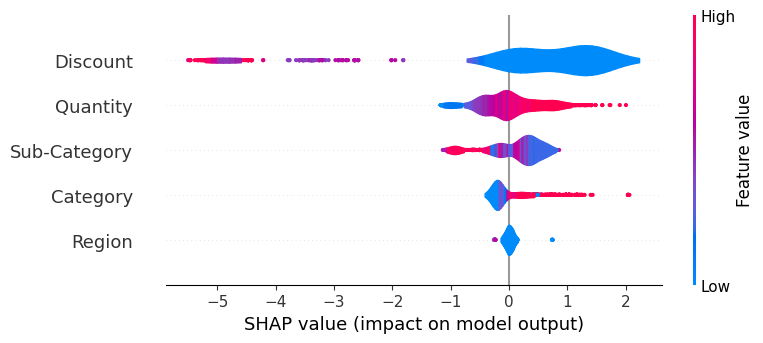

In [ ]:
shap.plots.violin(shap_values)

Interestingly, all five features have some influence when using XGBoost.  Sub-Category, which played no role in linear regression or SVM, has on average the third largest shapley values of the five features.  Perhaps XGBoost's decision trees were able to pick up a relationship between sub-category and profit that the simpler models were unable to.

## Deployment
### Huggingface Space Link: https://huggingface.co/spaces/JohnG112358/DALI2024S

### Citations
I learned about Gradio and Huggingface Spaces from:
- https://www.gradio.app/docs  \
- https://huggingface.co/docs/hub/en/spaces-overview

I deployed the best performing model for each model type.  Users can input their own predictions and see how each model behaves.  The gradio interface of my deployment can also be found below.

In [ ]:
region_label = {'Central': 0, 'East': 1, 'South': 2, 'West': 3}
category_label = {'Furniture': 0, 'Office Supplies': 1, 'Technology': 2}
sub_category_label = {'Accessories': 0, 'Appliances': 1, 'Art': 2, 'Binders': 3, 'Bookcases': 4,
       'Chairs': 5, 'Copiers': 6, 'Envelopes': 7, 'Fasteners': 8, 'Furnishings': 9,
       'Labels': 10, 'Machines': 11, 'Paper': 12, 'Phones': 13, 'Storage': 14, 'Supplies': 15,
       'Tables': 16}
profit_label = {0: 'Below Median Profit', 1: 'Above Median Profit'}
feature_names = ["Region", "Category", "Sub-Category", "Quantity", "Discount"]

# ensure features are valid
def sanitize_inputs(Region, Category, Sub_Category, Quantity, Discount):
  try:
    Region = region_label[Region]
    Category = category_label[Category]
    Sub_Category = sub_category_label[Sub_Category]
  except KeyError:
    return ["Please provide region, category, and sub category from the pre-defined Superstore dataset classes", None]

  if Quantity < 1 or Discount < 0:
    return ["Quantity and Discount must be positive", None]

  if not isinstance(Quantity, int):
    return ["Quantity must be an integer", None]

  if Discount > 1:
     return ["Discount cannot be greater than one", None]

  return [Region, Category, Sub_Category]

def XGB_predict(Region, Category, Sub_Category, Quantity, Discount):
  sanitized = sanitize_inputs(Region, Category, Sub_Category, Quantity, Discount)

  if len(sanitized)==2:
    return sanitized

  input = np.array([[sanitized[0], sanitized[1], sanitized[2], Quantity, Discount]])
  predicted_class = XGB.predict(input)

  explainer = shap.Explainer(XGB, test)
  shap_values = explainer(input)
  shap_values.feature_names = ["Region", "Category", "Sub-Category", "Quantity", "Discount"]

  plot = shap.plots.bar(shap_values, show=False)
  plt.savefig('shap_plot_XGB.png')

  return [profit_label[predicted_class[0]], 'shap_plot_XGB.png']

def SVM_predict(Region, Category, Sub_Category, Quantity, Discount):
  sanitized = sanitize_inputs(Region, Category, Sub_Category, Quantity, Discount)

  if len(sanitized)==2:
    return sanitized

  input = np.array([[sanitized[0], sanitized[1], sanitized[2], Quantity, Discount]])
  predicted_class = SVM.predict(input)

  explainer = shap.Explainer(SVM, test)
  shap_values = explainer(input)
  shap_values.feature_names = ["Region", "Category", "Sub-Category", "Quantity", "Discount"]

  plot = shap.plots.bar(shap_values, show=False)
  plt.savefig('shap_plot_SVM.png')

  return [profit_label[predicted_class[0]], 'shap_plot_SVM.png']

def Log_reg_predict(Region, Category, Sub_Category, Quantity, Discount):
  sanitized = sanitize_inputs(Region, Category, Sub_Category, Quantity, Discount)

  if len(sanitized)==2:
    return sanitized

  input = np.array([[sanitized[0], sanitized[1], sanitized[2], Quantity, Discount]])
  predicted_class = Log_Reg.predict(input)

  explainer = shap.Explainer(Log_Reg, test)
  shap_values = explainer(input)
  shap_values.feature_names = ["Region", "Category", "Sub-Category", "Quantity", "Discount"]

  plot = shap.plots.bar(shap_values, show=False)
  plt.savefig('shap_plot_LogReg.png')

  return [profit_label[predicted_class[0]], 'shap_plot_LogReg.png']

In [ ]:
# one tab for each model
LogReg_tab = gr.Interface(
    fn=Log_reg_predict,
    inputs=["text", "text", "text", "number", "number"],
    outputs=[
        gr.Label(label="Model Prediction"),
        gr.Image(label="Shapley Values"),
    ],
    title="Logistic Regression Profit Prediction",
    description="Create your own purchases and see if the Logistic Regression model predicts they will make above or below the median profit\n\nValid regions: ['Central', 'East', 'South', 'West']\n\nValid product categories: ['Furniture', 'Office Supplies', 'Technology']\n\nValid product sub-categories: ['Accessories', 'Appliances', 'Art', 'Binders', 'Bookcases', 'Chairs', 'Copiers', 'Envelopes', 'Fasteners', 'Furnishings', 'Labels', 'Machines', 'Paper', 'Phones', 'Storage', 'Supplies', 'Tables']",
)

SVM_tab = gr.Interface(
    fn=SVM_predict,
    inputs=["text", "text", "text", "number", "number"],
    outputs=[
        gr.Label(label="Model Prediction"),
        gr.Image(label="Shapley Values"),
    ],
    title="SVM Profit Prediction",
    description="Create your own purchases and see if the SVM model predicts they will make above or below the median profit\n\nValid regions: ['Central', 'East', 'South', 'West']\n\nValid product categories: ['Furniture', 'Office Supplies', 'Technology']\n\nValid product sub-categories: ['Accessories', 'Appliances', 'Art', 'Binders', 'Bookcases', 'Chairs', 'Copiers', 'Envelopes', 'Fasteners', 'Furnishings', 'Labels', 'Machines', 'Paper', 'Phones', 'Storage', 'Supplies', 'Tables']",
)

XGB_tab = gr.Interface(
    fn=XGB_predict,
    inputs=["text", "text", "text", "number", "number"],
    outputs=[
        gr.Label(label="Model Prediction"),
        gr.Image(label="Shapley Values"),
    ],
    title="XGB Profit Prediction",
    description="Create your own purchases and see if the XGB model predicts they will make above or below the median profit\n\nValid regions: ['Central', 'East', 'South', 'West']\n\nValid product categories: ['Furniture', 'Office Supplies', 'Technology']\n\nValid product sub-categories: ['Accessories', 'Appliances', 'Art', 'Binders', 'Bookcases', 'Chairs', 'Copiers', 'Envelopes', 'Fasteners', 'Furnishings', 'Labels', 'Machines', 'Paper', 'Phones', 'Storage', 'Supplies', 'Tables']",
)



demo = gr.TabbedInterface([LogReg_tab, SVM_tab, XGB_tab], tab_names=["Logistic Regression", "SVM", "XGB"], theme=gr.themes.Soft())

demo.launch(debug=True, share=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://2fcd20c8d2928c6f13.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://2fcd20c8d2928c6f13.gradio.live
